# Program for Gaussian Radial Basis Function Regression
## ECE - 411 - Computational Graphs for Machine Learning
## Professor Chris Curro
## Homework Assignment #1
## January 29, 2017

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

N = 50; # Number of samples
#Hyper parameters
M = 6;
runs = 100; 
rateLearn = 1e-2;
regConst = 0; 
sigmaNoise = 0.1
muNoise = 0

In [2]:
#Floating functions 

def origFunc(x):
	return np.sin(2 * np.pi * x);

def gaussian(x, mu, sigma):
	return tf.exp(-0.5*(x-mu)**2/sigma**2);

def data():
    for _ in range(N):
        x = np.random.uniform()
        y  = origFunc(x) + np.random.normal(loc = muNoise, scale = sigmaNoise)
        yield x, y

def defVariable(shape, name):
        var = tf.get_variable(name=name,
                                   dtype=tf.float32,
                                   shape=shape,
                                   initializer=tf.random_uniform_initializer(minval=-1.5, maxval=1.5)
        )
        tf.add_to_collection('modelVars', var)
        tf.add_to_collection('l2', tf.reduce_sum(tf.pow(var,2)))
        return var

In [3]:
class GaussianRBFModel():
    def __init__(self, sess, data, iterations, learnRate, gamma):
        self.sess = sess
        self.data = data
        self.iterations = iterations
        self.learnRate = learnRate
        self.gamma = gamma
        self.buildModel()
        
    def buildModel(self):
        self.x = tf.placeholder(tf.float32, shape=[])
        self.y = tf.placeholder(tf.float32, shape=[])
        
        w = defVariable([1, M], 'w')
        mu = defVariable([M,1], 'mu')
        sigma = defVariable([M,1], 'sigma')
        b = defVariable([], 'b')
        phiArr = np.array([])

        for k in range(M):
        	phiArr = np.append(phiArr, gaussian(self.x, mu[k], sigma[k]));
        phi = tf.stack(phiArr.tolist()); 

        self.yhat = b + tf.matmul(w, phi); 
        self.mse = tf.reduce_mean(0.5*tf.square(self.yhat - self.y))
        self.l2_penalty = tf.reduce_sum(tf.get_collection('l2'))
        self.loss = self.mse + self.gamma * self.l2_penalty; 

    def initTrainer(self):
        modelVars = tf.get_collection('modelVars')            
        self.optim = (tf.train.GradientDescentOptimizer(learning_rate=self.learnRate).minimize(self.loss, var_list=modelVars))
        self.sess.run(tf.global_variables_initializer())

    def iterateTrainer(self, step, x, y):
        loss, _ = self.sess.run([self.loss,self.optim],
                                          feed_dict={self.x : x, self.y : y})
        #if step % 20 == 0: 
        	#print('Step: {} \t Loss: {}'.format(step, loss))
     
    def train(self):
        for step in range(self.iterations+1):
            for x, y in self.data():
                self.iterateTrainer(step, x, y)

    def infer(self, x):
    	y = np.asscalar(self.sess.run(self.yhat, feed_dict={self.x : x}))
    	#print(x, y);
    	return y; 

In [4]:
sess = tf.Session()
model = GaussianRBFModel(sess, data, iterations=runs, learnRate=rateLearn, gamma=regConst)
model.initTrainer()
model.train()

with tf.variable_scope("", reuse = True):
	w = sess.run(tf.get_variable("w"))
	mu = sess.run(tf.transpose(tf.get_variable("mu")))
	sigma = sess.run(tf.transpose(tf.get_variable("sigma")))
	b = sess.run(tf.get_variable("b"));  

print("W =", w); 
print("μ =", mu); 
print("σ =", sigma); 
print("b =", b); 

W = [[ 0.78901613 -0.00161124 -0.88075727  1.14713728 -1.36029589  1.15635121]]
μ = [[ 0.67456335 -0.68902916  0.75128853 -0.99203062  0.15439349  0.26192334]]
σ = [[-1.05152214 -1.39234996  0.12625717  0.77023715  1.23775458  0.15062161]]
b = 0.212866


In [5]:
x_model = np.linspace(0.0, 1.0, 100); 

y_model = []; 

for a in x_model: 
	y_model.append(model.infer(a)); 
y_model = np.array(y_model); 

x_real = np.linspace(0.0, 1.0, 100); 
y_real = origFunc(x_real);  

examples, targets = zip(*list(data()))

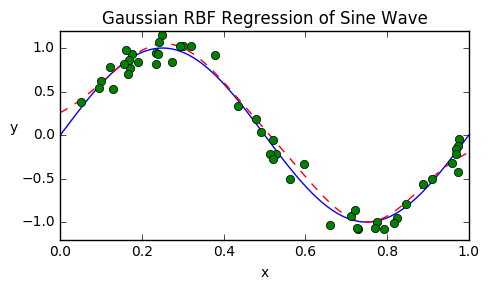

In [6]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5, 3)
plt.plot(x_real, y_real, 'b-', x_model, y_model, 'r--', np.array(examples), np.array(targets), 'go')
plt.xlim([0.0, 1.0])
plt.ylim([-1.2, 1.2])
ax.set_xlabel('x')
ax.set_ylabel('y').set_rotation(0)
plt.title('Gaussian RBF Regression of Sine Wave')
plt.tight_layout()
plt.show()

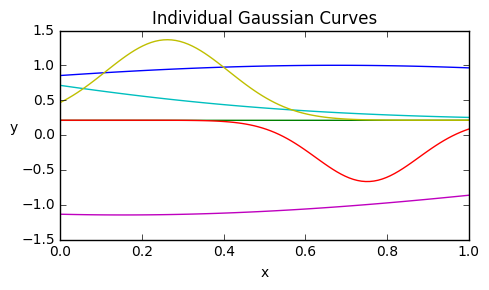

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5, 3)
ax.set_xlabel('x')
ax.set_ylabel('y').set_rotation(0)
plt.xlim([0.0,1.0]);
plt.ylim([-2,2]); 
plt.title('Individual Gaussian Curves')
plt.tight_layout()
ax.autoscale(enable=True, axis='y', tight=False)

x_gauss = np.linspace(0.0, 1.0, 100); 
for k in range(M):
	with sess.as_default():
		y_gauss = np.asscalar(w[0][k]) * gaussian(x_gauss, mu[0][k], sigma[0][k]).eval() + b;
	plt.plot(x_gauss, y_gauss); 
plt.show(); 